In [1]:
import seaborn as sns
import pickle
import os
import numpy as np
import pandas as pd
import scanpy
import umap
import networkx as nx
import torch
import torch.nn as nn
import scvelo as scv

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter
from veloproj import *


In [2]:
method_name_mapping = {"stc_mode":"RawDim", 
 "Cohort AutoEncoder":"LowDim",
 "Baseline AutoEncoder":"AE",
 "Ablation GCN Only": "veloAE w/ CohAgg",
 "Ablation AttComb Only": "veloAE w/ AttComb",
 "Baseline PCA": "PCA",
 "Baseline FA": "FA",                       
 }

def short_metric_name(metric):
    return {"Cross-Boundary Transition Score (A->B)":"CBTrans",
                  "Cross-Boundary Velocity Coherence (A->B)":"CBVCoh",
                  "Cross-Boundary Direction Correctness (A->B)":"CBDir",
                  "In-cluster Confidence":"ICConf",
                  "In-cluster Coherence":"ICVCoh"
                 }[metric]

def dis_method_name(method):
    return method_name_mapping.get(method, None)

def dis_group_name(group, metric):
    return "->".join(group) if metric.startswith('CB') else group
    
def to_dataframe(res):
    df_data = []
    for method, method_res in res.items():
        method = dis_method_name(method)
        if method is None:
            continue
        print(method)
        for metric, metric_res in method_res.items():
            metric = short_metric_name(metric)
            print(metric)
            for group, values in metric_res.items():
                group = dis_group_name(group, metric)
                print("\t", group, ": ", np.mean(values))
                for a_score in values:
                    df_data.append({"space":method,
                                    "metric":metric,
                                    "group": group,
                                    "score": a_score
                                   })
    df_data = pd.DataFrame(df_data)
    return df_data

def generate_plots(df_data, dataset, cbgroups, icgroups):
    for i, m in enumerate(df_data.metric.unique(), 1):
        print(m)
        df = df_data.query('metric == "{}"'.format(m))
        tgt_group = cbgroups if m.startswith("CB") else icgroups
        dfs = [df.query('group == "{}"'.format(grp)) for grp in tgt_group]
        if len(dfs) == 0:
            continue
        df = pd.concat(dfs, ignore_index=True)
        g = sns.catplot(x="space", y="score",
                    data=df, kind="box",
                    palette="Set3",
                    showfliers = False,   
                   )
        g.savefig("./figures/{}_{}".format(dataset, m), dpi=350)

def generate_plots(df_data, dataset, cbgroups, icgroups):
    for i, m in enumerate(df_data.metric.unique(), 1):
        print(m)
        df = df_data.query('metric == "{}"'.format(m))
        tgt_group = cbgroups if m.startswith("CB") else icgroups
        dfs = [df.query('group == "{}"'.format(grp)) for grp in tgt_group]
        if len(dfs) == 0:
            continue
        df = pd.concat(dfs, ignore_index=True)
        g = sns.catplot(x="space", y="score",
                    data=df, kind="box",
                    palette="Set3",
                    showfliers = False,   
                   )
        g.savefig("./figures/{}_{}".format(dataset, m), dpi=350)
            

## Generate boxplots for metrics

RawDim
CBTrans
	 0->15 :  0.18048683
	 15->30 :  0.18492232
	 30->60 :  0.23317656
	 60->120 :  0.26242754
CBVCoh
	 0->15 :  0.8819104
	 15->30 :  0.84926486
	 30->60 :  0.88575625
	 60->120 :  0.9494799
CBDir
	 0->15 :  0.1881905019999878
	 15->30 :  0.183201596664333
	 30->60 :  0.26051693615496574
	 60->120 :  0.37970625224987553
ICVCoh
	 0 :  0.91480386
	 120 :  0.9610714
	 15 :  0.8690307
	 30 :  0.8744445
	 60 :  0.95124406
ICConf
	 0 :  0.5655584201816745
	 120 :  0.5211345913163219
	 15 :  0.5152941769720372
	 30 :  0.5523725957590283
	 60 :  0.630686758869792
LowDim
CBTrans
	 0->15 :  0.428741
	 15->30 :  0.3979588
	 30->60 :  0.3231491
	 60->120 :  0.3039136
CBVCoh
	 0->15 :  0.95277965
	 15->30 :  0.94163996
	 30->60 :  0.95748305
	 60->120 :  0.9809529
CBDir
	 0->15 :  0.7355243132464214
	 15->30 :  0.4161056869955898
	 30->60 :  0.2720055084825809
	 60->120 :  0.1860407980645423
ICVCoh
	 0 :  0.96375793
	 120 :  0.98031217
	 15 :  0.94525844
	 30 :  0.9501985
	 60 :  0.980

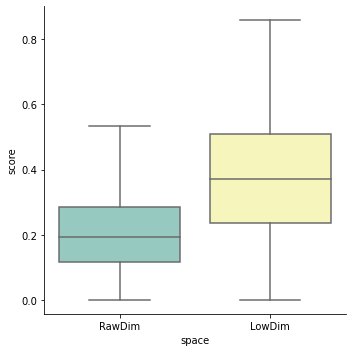

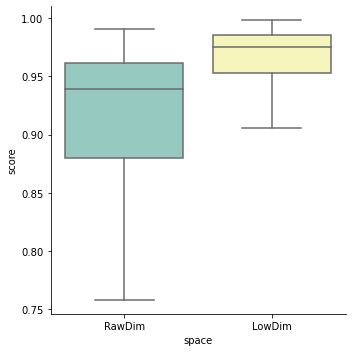

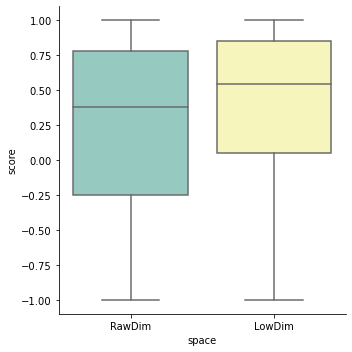

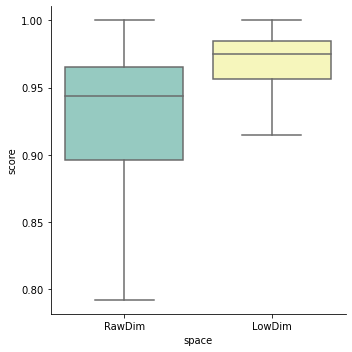

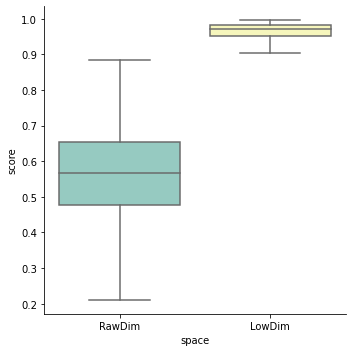

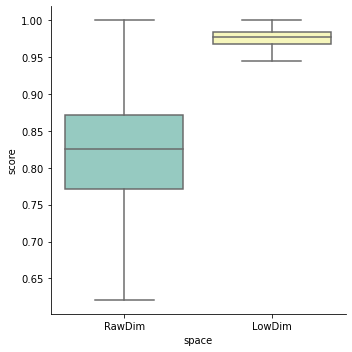

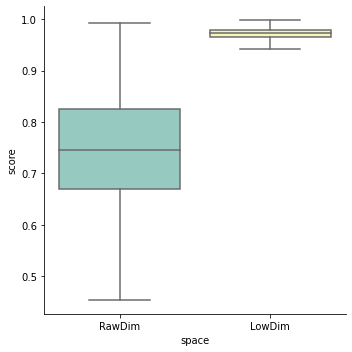

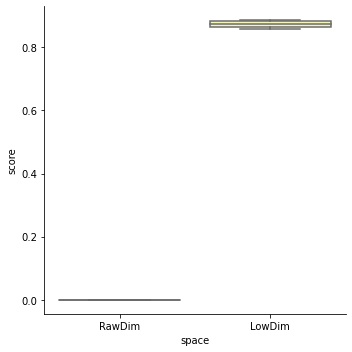

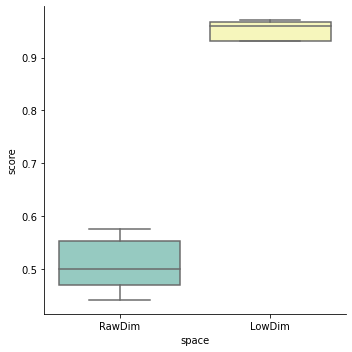

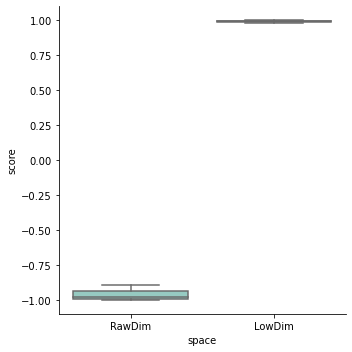

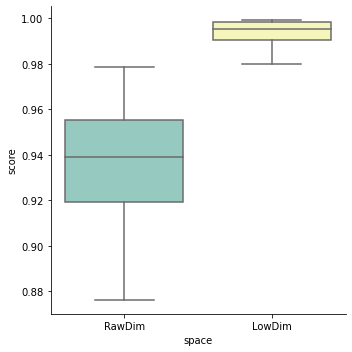

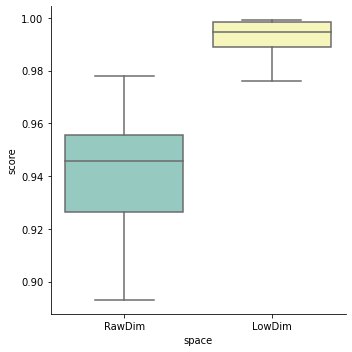

In [3]:
if not os.path.exists("./figures"):
    os.makedirs("./figures")
    
paths = ["../scNTseq/CohAE_scNT.pkl", "../scEUseq/CohAE_scEU.pkl", "../dentategyrus/CohAE_dentategyrus.pkl"]
groups = [(["0->15", "15->30", "30->60", "60->120"], ["0", "15", "30", "60", "120"]), ([], [1, 2]), (['OPC->OL'],['OPC', 'OL'])]
dfs = []
for path, (cbg, icg) in zip(paths, groups): 
    dataset = path.split("_")[-1].split(".")[0]
    with open(path, 'rb') as infile:
        df = to_dataframe(pickle.load(infile))
        generate_plots(df, dataset, cbg, icg)
    dfs.append(df)

##  Compute Scores for Table

In [4]:
datasets = ["scNTseq", "scEUseq", "dentategyrus"]
groups = [(["0->15", "15->30", "30->60", "60->120"], ["0", "15", "30", "60", "120"]), ([], [1, 2]), (['OPC->OL'],['OPC', 'OL'])]
dfs = []
for dataset, (cbg, icg) in zip(datasets, groups):
    _dfs = []
    for prefix in ['baseline', 'CohAE']:
        path = "../{}/{}_{}.pkl".format(dataset, prefix, dataset[:4] if not dataset == "dentategyrus" else dataset)
        with open(path, 'rb') as infile:
            _dfs.append(to_dataframe(pickle.load(infile)))
    _dfs[0] = _dfs[0].loc[_dfs[0].space != "RawDim", :] # keep only those in CohAE results
    df = pd.concat(_dfs, ignore_index=True)            
    dfs.append(df)

RawDim
CBTrans
	 0->15 :  0.18047157
	 15->30 :  0.18490802
	 30->60 :  0.23314989
	 60->120 :  0.26255786
CBVCoh
	 0->15 :  0.882237
	 15->30 :  0.84970397
	 30->60 :  0.8860251
	 60->120 :  0.94955367
CBDir
	 0->15 :  0.1873846970844583
	 15->30 :  0.18306115502453824
	 30->60 :  0.2604929039751113
	 60->120 :  0.37984779735682245
ICVCoh
	 0 :  0.9150234
	 120 :  0.96112585
	 15 :  0.86938363
	 30 :  0.8747749
	 60 :  0.9513406
ICConf
	 0 :  0.5655337789948088
	 120 :  0.5211500842643686
	 15 :  0.5152785540017158
	 30 :  0.5523610212043529
	 60 :  0.6307097600359652
AE
CBTrans
	 0->15 :  0.06473316
	 15->30 :  0.05953183
	 30->60 :  0.057702873
	 60->120 :  0.11700469
CBVCoh
	 0->15 :  0.94679576
	 15->30 :  0.9301643
	 30->60 :  0.9530374
	 60->120 :  0.98190385
CBDir
	 0->15 :  0.6086923204979175
	 15->30 :  0.02783302671911441
	 30->60 :  0.19227679406858628
	 60->120 :  0.4284121407894661
ICVCoh
	 0 :  0.9659324
	 120 :  0.9881581
	 15 :  0.93617195
	 30 :  0.9435209
	 60 :  0.9

In [5]:
datasets = ["scNT", "scEU", "dentategyrus"]
mean_records = {}
std_records = {}

for dataset, df, group in zip(datasets, dfs, groups):
    for method in df.space.unique():
        m_df = df.query('space == "{}"'.format(method))
        avg_metric, std_metric = {}, {}
        for metric in m_df.metric.unique():
            _group = group[0] if metric.startswith("CB") else group[1]
            if len(_group) == 0: continue
            loc_df = m_df.query('metric == "{}"'.format(metric))
            loc_df = pd.concat([loc_df.query('group == "{}"'.format(_g)) for _g in _group], ignore_index=True)
            avg_metric["{}_{}".format(dataset, metric)] =  loc_df.groupby('group').mean().score.mean()
            std_metric["{}_{}".format(dataset, metric)] = loc_df.groupby('group').std().score.mean()
        if not method in mean_records:
            mean_records[method] = {}
            std_records[method] = {}
        mean_records[method].update(avg_metric)
        std_records[method].update(std_metric)

df_mean = pd.DataFrame(mean_records).T
new_index = df_mean.index.values
new_index[new_index == "LowDim"] = "veloAE"
new_index[new_index == "RawDim"] = "scVelo"
df_mean.index = new_index
df_std = pd.DataFrame(std_records).T
df_std.index = new_index        

In [6]:
df_mean.loc[['scVelo', 'FA', 'PCA', 'AE', 'veloAE', "veloAE w/ CohAgg", "veloAE w/ AttComb"],
            ['scNT_ICConf', 'scNT_ICVCoh',  
             'scNT_CBTrans', 'scNT_CBVCoh', 'scNT_CBDir', 
             'dentategyrus_ICConf',  'dentategyrus_ICVCoh', 'dentategyrus_CBTrans',
             'dentategyrus_CBVCoh', 'dentategyrus_CBDir',
             'scEU_ICConf', 'scEU_ICVCoh',
            ]]

,scNT_ICConf,scNT_ICVCoh,scNT_CBTrans,scNT_CBVCoh,scNT_CBDir,dentategyrus_ICConf,dentategyrus_ICVCoh,dentategyrus_CBTrans,dentategyrus_CBVCoh,dentategyrus_CBDir,scEU_ICConf,scEU_ICVCoh
scVelo,0.557009,0.914119,0.215253,0.891603,0.252904,0.937411,0.936343,0.000000,0.508538,-0.886101,0.755290,0.829744
FA,0.809882,0.828903,0.097749,0.790291,-0.114625,0.941881,0.945375,0.101896,0.665487,0.068269,0.755805,0.794526
PCA,0.937716,0.943255,0.015625,0.925079,0.275802,0.977723,0.982415,0.000000,0.528976,-0.812564,0.910866,0.923098
AE,0.940085,0.963864,0.074743,0.952975,0.314304,0.983409,0.991129,0.000000,0.768458,-0.816379,0.957370,0.983828
veloAE,0.959494,0.964090,0.363441,0.958214,0.402419,0.991210,0.992157,0.873375,0.936727,0.986276,0.966286,0.970928
veloAE w/ CohAgg,0.949180,0.953369,0.076748,0.937944,0.405533,0.974285,0.977594,0.355217,0.599966,0.947341,0.923268,0.933144
veloAE w/ AttComb,0.963218,0.965888,0.389842,0.957776,-0.095814,0.993938,0.995379,0.838894,0.907880,0.984630,0.977225,0.980528


In [7]:
# keep only ICVCoh and CBDir for paper
print(df_mean.loc[['scVelo', 'FA', 'PCA', 'AE', 'veloAE', "veloAE w/ CohAgg", "veloAE w/ AttComb"],
                  ['scNT_ICVCoh', 'scNT_CBDir',
                   'dentategyrus_ICVCoh', 'dentategyrus_CBDir',
                   'scEU_ICVCoh',
                   ]].to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  scNT\_ICVCoh &  scNT\_CBDir &  dentategyrus\_ICVCoh &  dentategyrus\_CBDir &  scEU\_ICVCoh \\
\midrule
scVelo            &     0.914119 &    0.252904 &             0.936343 &           -0.886101 &     0.829744 \\
FA                &     0.828903 &   -0.114625 &             0.945375 &            0.068269 &     0.794526 \\
PCA               &     0.943255 &    0.275802 &             0.982415 &           -0.812564 &     0.923098 \\
AE                &     0.963864 &    0.314304 &             0.991129 &           -0.816379 &     0.983828 \\
veloAE            &     0.964090 &    0.402419 &             0.992157 &            0.986276 &     0.970928 \\
veloAE w/ CohAgg  &     0.953369 &    0.405533 &             0.977594 &            0.947341 &     0.933144 \\
veloAE w/ AttComb &     0.965888 &   -0.095814 &             0.995379 &            0.984630 &     0.980528 \\
\bottomrule
\end{tabular}

